# Data Exploration: French-German Legal Translation Corpus

This notebook explores the preprocessed CJEU (Court of Justice of the European Union) preliminary reference rulings dataset for neural machine translation.

**Dataset:** French → German parallel paragraphs from CJEU judgments (2000s onwards)

**Source:** EUR-Lex API via eurlex R package

**Alignment method:** Numbered paragraph matching (precise alignment)

---

## 1. Setup and Data Loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import re
from typing import List, Dict

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load preprocessed parallel paragraphs
data_path = Path("../data/processed/parallel_paragraphs.jsonl")

# Read JSONL file
data = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)

print(f"Loaded {len(df)} paragraph pairs")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head(3)

Loaded 1055 paragraph pairs

DataFrame shape: (1055, 8)

Columns: ['id', 'source_text', 'target_text', 'celex_id', 'source_tokens', 'target_tokens', 'alignment_method', 'paragraph_number']


,id,source_text,target_text,celex_id,source_tokens,target_tokens,alignment_method,paragraph_number
0,62009CJ0296_para0001,La demande de décision préjudicielle porte sur...,Das Vorabentscheidungsersuchen betrifft die Au...,62009CJ0296,123,110,numbered_paragraph,1
1,62009CJ0296_para0002,Cette demande a été présentée dans le cadre d’...,Dieses Ersuchen ergeht im Rahmen eines Rechtss...,62009CJ0296,40,33,numbered_paragraph,2
2,62009CJ0296_para0003,"L’article 2 du règlement n° 1408/71, intitulé ...",Art. 2 („Persönlicher Geltungsbereich“) der Ve...,62009CJ0296,23,20,numbered_paragraph,3


## 2. Basic Statistics

Overview of the dataset size, document coverage, and alignment quality.

In [3]:
# Basic statistics
print("="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Total paragraph pairs: {len(df):,}")
print(f"Unique documents: {df['celex_id'].nunique()}")
print(f"Alignment method: {df['alignment_method'].unique()[0]}")
print(f"\nParagraphs per document:")
print(f"  Mean: {df.groupby('celex_id').size().mean():.1f}")
print(f"  Median: {df.groupby('celex_id').size().median():.0f}")
print(f"  Min: {df.groupby('celex_id').size().min()}")
print(f"  Max: {df.groupby('celex_id').size().max()}")
print(f"\nToken statistics (French):")
print(f"  Mean: {df['source_tokens'].mean():.1f}")
print(f"  Median: {df['source_tokens'].median():.0f}")
print(f"  Min: {df['source_tokens'].min()}")
print(f"  Max: {df['source_tokens'].max()}")
print(f"\nToken statistics (German):")
print(f"  Mean: {df['target_tokens'].mean():.1f}")
print(f"  Median: {df['target_tokens'].median():.0f}")
print(f"  Min: {df['target_tokens'].min()}")
print(f"  Max: {df['target_tokens'].max()}")
print("="*60)

DATASET STATISTICS
Total paragraph pairs: 1,055
Unique documents: 17
Alignment method: numbered_paragraph

Paragraphs per document:
  Mean: 62.1
  Median: 60
  Min: 30
  Max: 98

Token statistics (French):
  Mean: 81.5
  Median: 73
  Min: 5
  Max: 353

Token statistics (German):
  Mean: 69.0
  Median: 61
  Min: 5
  Max: 295


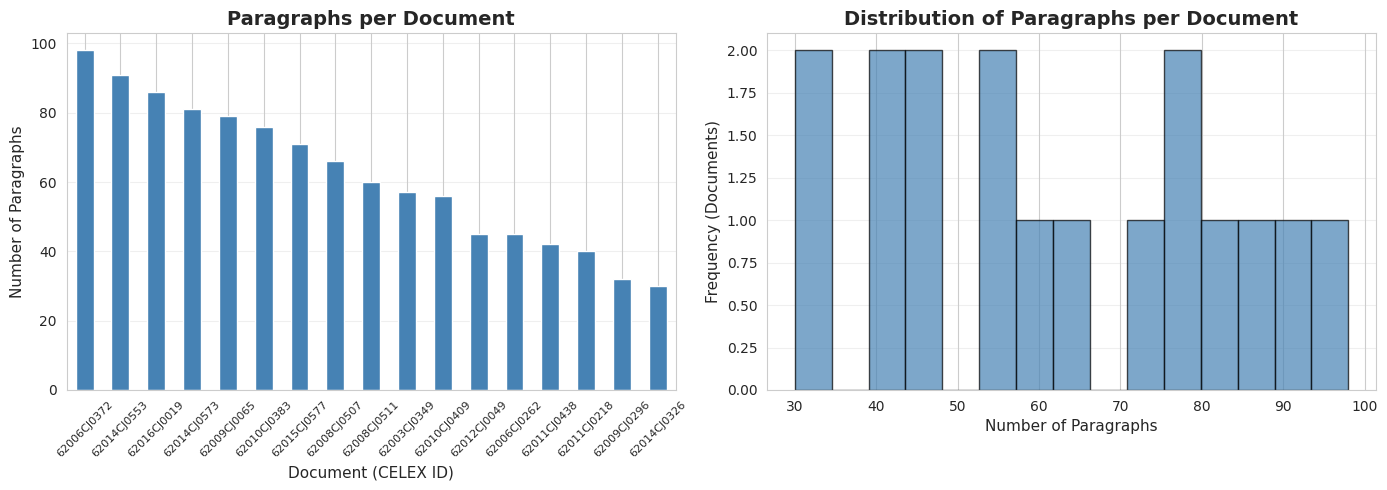


Documents with most paragraphs:
celex_id
62006CJ0372    98
62014CJ0553    91
62016CJ0019    86
62014CJ0573    81
62009CJ0065    79
dtype: int64


In [4]:
# Paragraphs per document distribution
paras_per_doc = df.groupby('celex_id').size().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
paras_per_doc.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Paragraphs per Document', fontsize=14, fontweight='bold')
ax1.set_xlabel('Document (CELEX ID)', fontsize=11)
ax1.set_ylabel('Number of Paragraphs', fontsize=11)
ax1.tick_params(axis='x', rotation=45, labelsize=8)
ax1.grid(axis='y', alpha=0.3)

# Histogram
ax2.hist(paras_per_doc, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Paragraphs per Document', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Paragraphs', fontsize=11)
ax2.set_ylabel('Frequency (Documents)', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDocuments with most paragraphs:")
print(paras_per_doc.head(5))

## 3. Length Distribution Analysis

Analyze token counts for French and German paragraphs to understand the typical length of training examples.

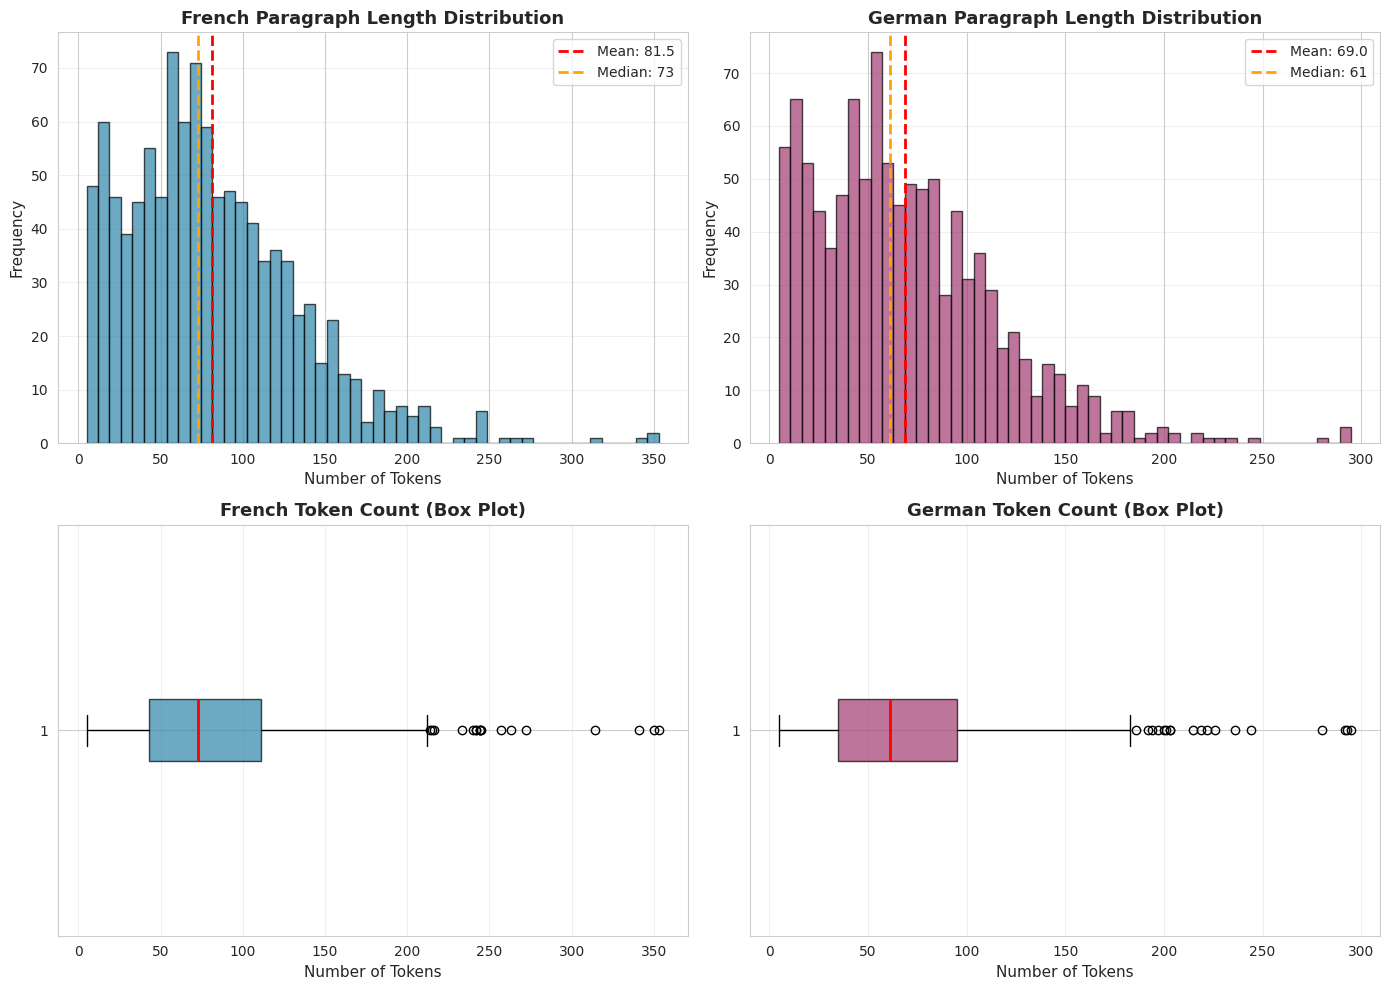

In [5]:
# Length distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# French token distribution (histogram)
axes[0, 0].hist(df['source_tokens'], bins=50, color='#2E86AB', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['source_tokens'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["source_tokens"].mean():.1f}')
axes[0, 0].axvline(df['source_tokens'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["source_tokens"].median():.0f}')
axes[0, 0].set_title('French Paragraph Length Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Number of Tokens', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# German token distribution (histogram)
axes[0, 1].hist(df['target_tokens'], bins=50, color='#A23B72', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['target_tokens'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["target_tokens"].mean():.1f}')
axes[0, 1].axvline(df['target_tokens'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["target_tokens"].median():.0f}')
axes[0, 1].set_title('German Paragraph Length Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Number of Tokens', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# French box plot
axes[1, 0].boxplot(df['source_tokens'], vert=False, patch_artist=True,
                    boxprops=dict(facecolor='#2E86AB', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_title('French Token Count (Box Plot)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Number of Tokens', fontsize=11)
axes[1, 0].grid(axis='x', alpha=0.3)

# German box plot
axes[1, 1].boxplot(df['target_tokens'], vert=False, patch_artist=True,
                    boxprops=dict(facecolor='#A23B72', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_title('German Token Count (Box Plot)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Number of Tokens', fontsize=11)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Length Ratio Analysis

Compare French vs German token counts to assess alignment quality. Well-aligned parallel paragraphs should have similar lengths.

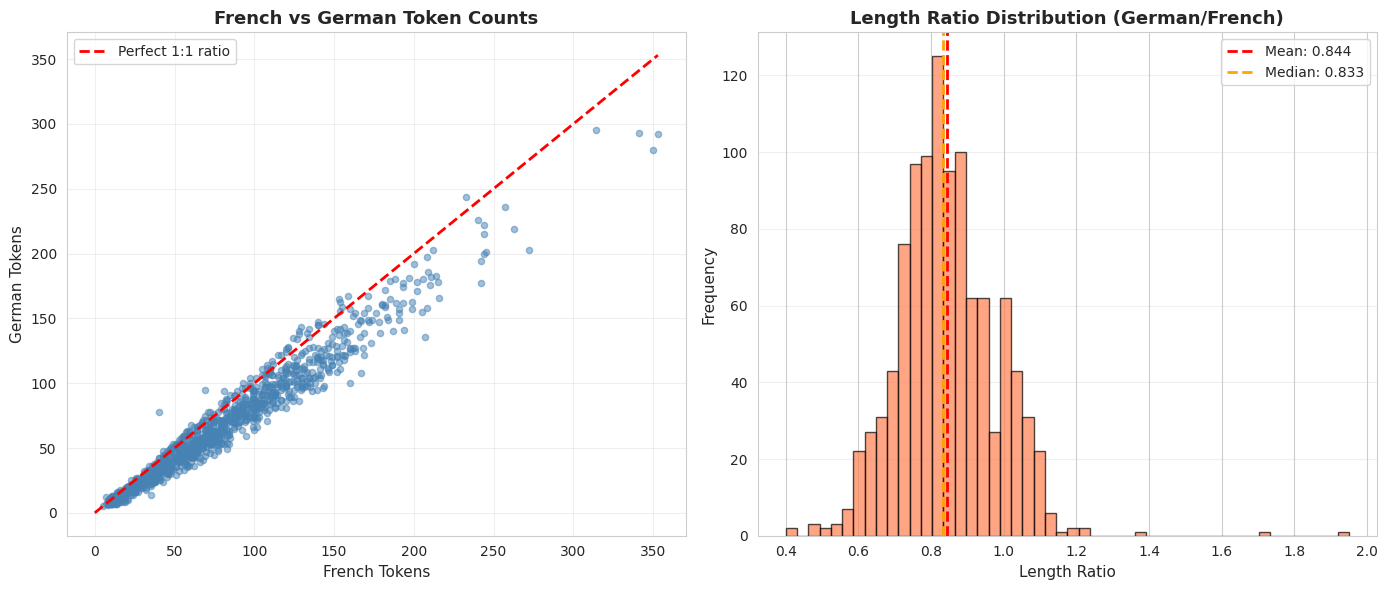


Length Ratio Statistics:
  Mean: 0.844
  Median: 0.833
  Std Dev: 0.136
  Min: 0.400
  Max: 1.950

Correlation (French vs German token counts): 0.977
(High correlation indicates good alignment quality)


In [6]:
# Calculate length ratio (German / French)
df['length_ratio'] = df['target_tokens'] / df['source_tokens']

# Scatter plot: French vs German token counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
ax1.scatter(df['source_tokens'], df['target_tokens'], alpha=0.5, s=20, color='steelblue')
ax1.plot([0, df['source_tokens'].max()], [0, df['source_tokens'].max()], 
         'r--', linewidth=2, label='Perfect 1:1 ratio')
ax1.set_title('French vs German Token Counts', fontsize=13, fontweight='bold')
ax1.set_xlabel('French Tokens', fontsize=11)
ax1.set_ylabel('German Tokens', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3)

# Length ratio distribution
ax2.hist(df['length_ratio'], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(df['length_ratio'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df["length_ratio"].mean():.3f}')
ax2.axvline(df['length_ratio'].median(), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {df["length_ratio"].median():.3f}')
ax2.set_title('Length Ratio Distribution (German/French)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Length Ratio', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLength Ratio Statistics:")
print(f"  Mean: {df['length_ratio'].mean():.3f}")
print(f"  Median: {df['length_ratio'].median():.3f}")
print(f"  Std Dev: {df['length_ratio'].std():.3f}")
print(f"  Min: {df['length_ratio'].min():.3f}")
print(f"  Max: {df['length_ratio'].max():.3f}")

# Correlation
correlation = df['source_tokens'].corr(df['target_tokens'])
print(f"\nCorrelation (French vs German token counts): {correlation:.3f}")
print("(High correlation indicates good alignment quality)")

## 5. Sample Paragraphs

Display random examples from the dataset to get a qualitative sense of the data quality.

In [7]:
# Display random samples
np.random.seed(42)
sample_indices = np.random.choice(df.index, size=min(8, len(df)), replace=False)
samples = df.loc[sample_indices]

print("="*80)
print("RANDOM SAMPLE PARAGRAPHS")
print("="*80)

for idx, row in samples.iterrows():
    print(f"\n[{row['id']}]")
    print(f"Document: {row['celex_id']} | Paragraph: {row['paragraph_number']} | FR tokens: {row['source_tokens']} | DE tokens: {row['target_tokens']}")
    print(f"\n🇫🇷 FRENCH:\n{row['source_text']}")
    print(f"\n🇩🇪 GERMAN:\n{row['target_text']}")
    print("\n" + "-"*80)

RANDOM SAMPLE PARAGRAPHS

[62015CJ0577_para0042]
Document: 62015CJ0577 | Paragraph: 42 | FR tokens: 29 | DE tokens: 19

🇫🇷 FRENCH:
Par conséquent, les considérations figurant dans l’arrêt attaqué n’étant entachées d’aucune erreur de droit, le deuxième moyen du pourvoi doit également être écarté.

🇩🇪 GERMAN:
Da die Erwägungen im angefochtenen Urteil frei von Rechtsfehlern sind, ist somit auch der zweite Rechtsmittelgrund zurückzuweisen.

--------------------------------------------------------------------------------

[62008CJ0511_para0014]
Document: 62008CJ0511 | Paragraph: 14 | FR tokens: 24 | DE tokens: 16

🇫🇷 FRENCH:
L’article 357 du BGB, intitulé «Effets juridiques de la rétractation et de la restitution», est libellé comme suit:

🇩🇪 GERMAN:
§ 357 BGB („Rechtsfolgen des Widerrufs und der Rückgabe“) legt fest:

--------------------------------------------------------------------------------

[62008CJ0511_para0028]
Document: 62008CJ0511 | Paragraph: 28 | FR tokens: 64 | DE tokens: 60

## 6. Vocabulary Analysis

Analyze the most frequent words in both languages to understand the lexical characteristics of legal text.

In [8]:
def get_word_frequencies(texts: List[str], top_n: int = 50) -> Counter:
    """Extract word frequencies from a list of texts."""
    word_pattern = re.compile(r'\b\w+\b', re.UNICODE)
    all_words = []
    
    for text in texts:
        words = word_pattern.findall(text.lower())
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

# Get top 50 words for each language
fr_top_words = get_word_frequencies(df['source_text'].tolist(), top_n=50)
de_top_words = get_word_frequencies(df['target_text'].tolist(), top_n=50)

print("Top 50 most frequent words extracted for both languages.")

Top 50 most frequent words extracted for both languages.


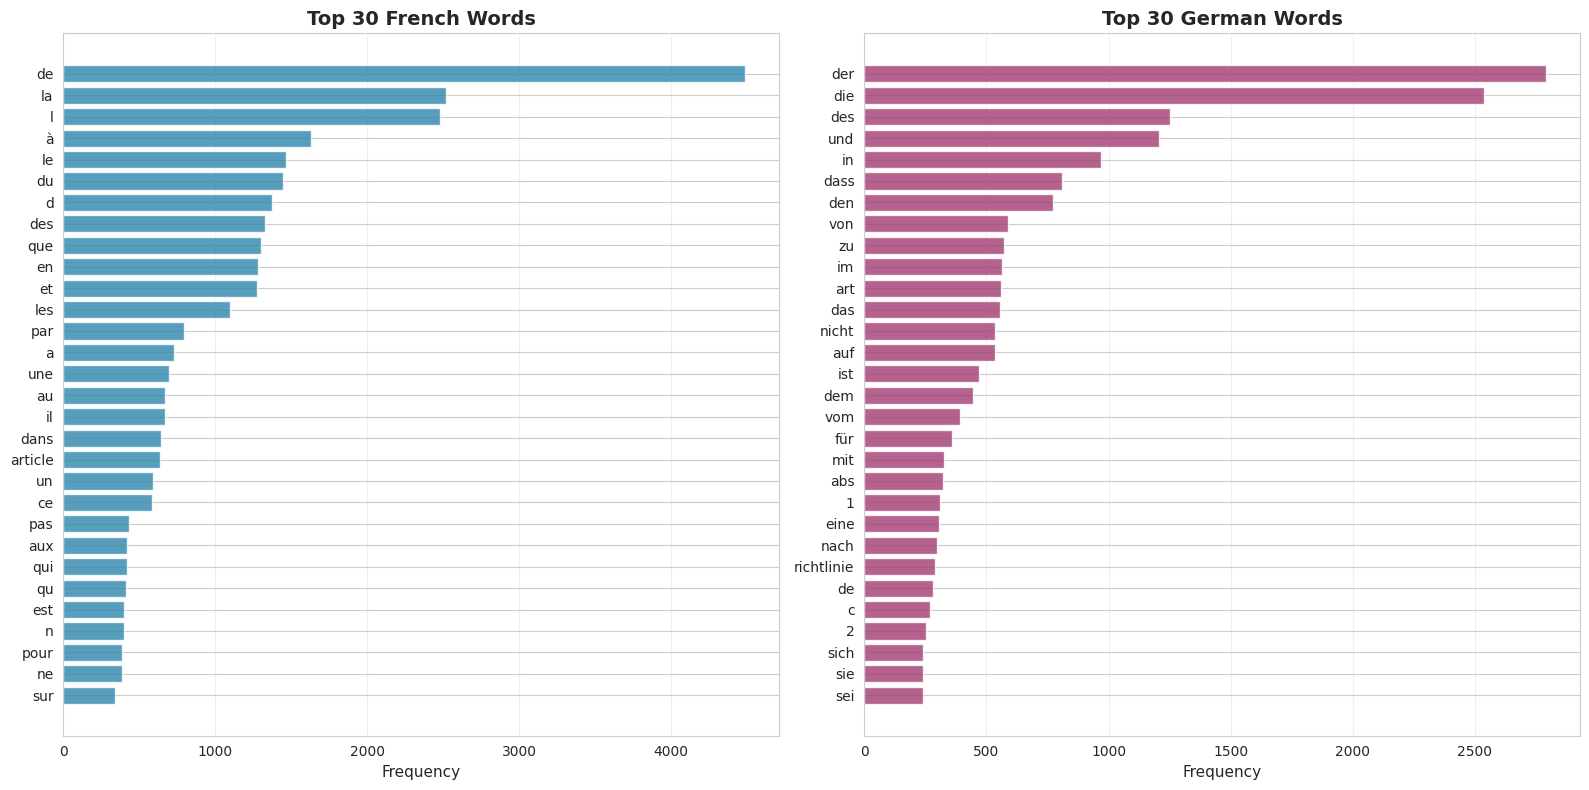

In [9]:
# Visualize top words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# French top words
fr_words, fr_counts = zip(*fr_top_words[:30])
ax1.barh(range(len(fr_words)), fr_counts, color='#2E86AB', alpha=0.8)
ax1.set_yticks(range(len(fr_words)))
ax1.set_yticklabels(fr_words)
ax1.invert_yaxis()
ax1.set_title('Top 30 French Words', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# German top words
de_words, de_counts = zip(*de_top_words[:30])
ax2.barh(range(len(de_words)), de_counts, color='#A23B72', alpha=0.8)
ax2.set_yticks(range(len(de_words)))
ax2.set_yticklabels(de_words)
ax2.invert_yaxis()
ax2.set_title('Top 30 German Words', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency', fontsize=11)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Print top words as tables
print("\n" + "="*60)
print("TOP 50 FRENCH WORDS")
print("="*60)
for i, (word, count) in enumerate(fr_top_words, 1):
    print(f"{i:2d}. {word:20s} {count:6,d}")

print("\n" + "="*60)
print("TOP 50 GERMAN WORDS")
print("="*60)
for i, (word, count) in enumerate(de_top_words, 1):
    print(f"{i:2d}. {word:20s} {count:6,d}")


TOP 50 FRENCH WORDS
 1. de                    4,486
 2. la                    2,519
 3. l                     2,477
 4. à                     1,627
 5. le                    1,464
 6. du                    1,445
 7. d                     1,373
 8. des                   1,327
 9. que                   1,299
10. en                    1,280
11. et                    1,271
12. les                   1,096
13. par                     796
14. a                       725
15. une                     695
16. au                      669
17. il                      666
18. dans                    645
19. article                 636
20. un                      592
21. ce                      581
22. pas                     432
23. aux                     419
24. qui                     419
25. qu                      411
26. est                     400
27. n                       399
28. pour                    387
29. ne                      383
30. sur                     338
31. cette          

## 7. Legal Terminology Analysis

Identify common legal terms using frequency analysis and domain-specific patterns.

In [11]:
# Define legal term patterns (case-insensitive)
fr_legal_patterns = [
    r'\barticle\b', r'\brèglement\b', r'\bdirective\b', r'\bjuridiction\b',
    r'\btribunal\b', r'\bcour\b', r'\bjurisprudence\b', r'\bdispositions\b',
    r'\bprocédure\b', r'\bparagraphe\b', r'\btraité\b', r'\blégislation\b',
    r'\binterprétation\b', r'\bprincipe\b', r'\bcompétence\b', r'\brequérant\b',
    r'\bdemandeur\b', r'\bdéfendeur\b', r'\barrêt\b', r'\bordonnance\b'
]

de_legal_patterns = [
    r'\bartikel\b', r'\bverordnung\b', r'\brichtlinie\b', r'\bgerichtshof\b',
    r'\bgericht\b', r'\brechtsprechung\b', r'\bbestimmungen\b', r'\bverfahren\b',
    r'\babsatz\b', r'\bvertrag\b', r'\brechtsvorschriften\b', r'\bauslegung\b',
    r'\bgrundsatz\b', r'\bzuständigkeit\b', r'\bkläger\b', r'\bbeklagte\b',
    r'\burteil\b', r'\bbeschluss\b', r'\bvorlage\b', r'\bvorabentscheidung\b'
]

def count_legal_terms(texts: List[str], patterns: List[str]) -> Dict[str, int]:
    """Count occurrences of legal terms matching given patterns."""
    term_counts = {}
    
    for pattern in patterns:
        count = 0
        for text in texts:
            count += len(re.findall(pattern, text, re.IGNORECASE))
        
        # Extract the word from the pattern (remove \b markers)
        term = pattern.replace('\\b', '')
        term_counts[term] = count
    
    return dict(sorted(term_counts.items(), key=lambda x: x[1], reverse=True))

# Count legal terms
fr_legal_terms = count_legal_terms(df['source_text'].tolist(), fr_legal_patterns)
de_legal_terms = count_legal_terms(df['target_text'].tolist(), de_legal_patterns)

print("Legal terms identified and counted.")

Legal terms identified and counted.


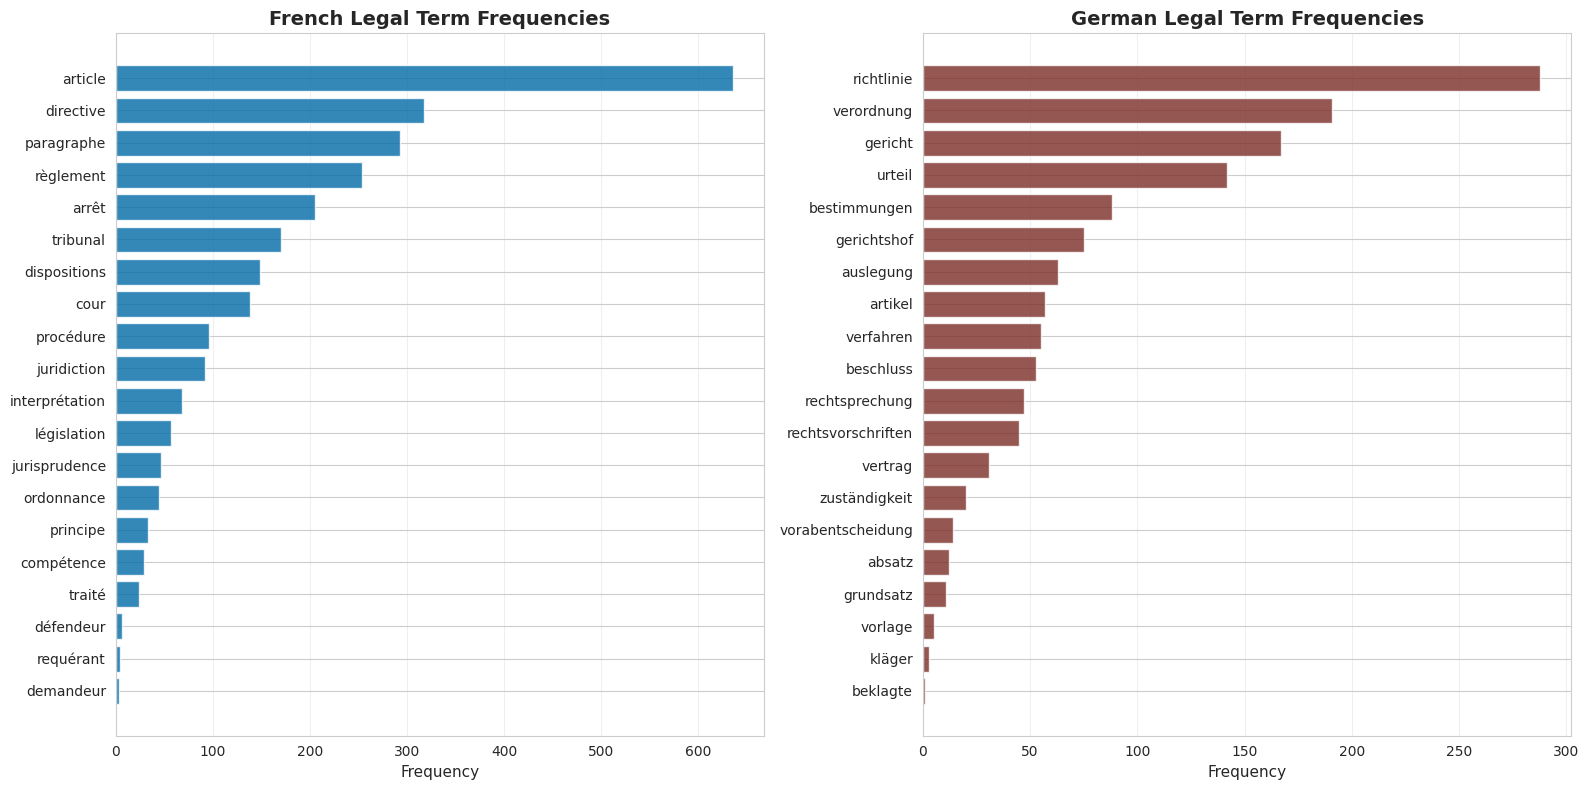


FRENCH LEGAL TERMS
article                      636
directive                    317
paragraphe                   293
règlement                    254
arrêt                        205
tribunal                     170
dispositions                 149
cour                         138
procédure                     96
juridiction                   92
interprétation                68
législation                   57
jurisprudence                 47
ordonnance                    45
principe                      33
compétence                    29
traité                        24
défendeur                      6
requérant                      4
demandeur                      3

GERMAN LEGAL TERMS
richtlinie                   288
verordnung                   191
gericht                      167
urteil                       142
bestimmungen                  88
gerichtshof                   75
auslegung                     63
artikel                       57
verfahren                     55
bes

In [12]:
# Visualize legal terms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# French legal terms
fr_terms = list(fr_legal_terms.keys())
fr_counts = list(fr_legal_terms.values())
ax1.barh(range(len(fr_terms)), fr_counts, color='#006BA6', alpha=0.8)
ax1.set_yticks(range(len(fr_terms)))
ax1.set_yticklabels(fr_terms)
ax1.invert_yaxis()
ax1.set_title('French Legal Term Frequencies', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# German legal terms
de_terms = list(de_legal_terms.keys())
de_counts = list(de_legal_terms.values())
ax2.barh(range(len(de_terms)), de_counts, color='#7B2D26', alpha=0.8)
ax2.set_yticks(range(len(de_terms)))
ax2.set_yticklabels(de_terms)
ax2.invert_yaxis()
ax2.set_title('German Legal Term Frequencies', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency', fontsize=11)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FRENCH LEGAL TERMS")
print("="*60)
for term, count in fr_legal_terms.items():
    print(f"{term:25s} {count:6,d}")

print("\n" + "="*60)
print("GERMAN LEGAL TERMS")
print("="*60)
for term, count in de_legal_terms.items():
    print(f"{term:25s} {count:6,d}")

## 8. Data Quality Checks

Identify potential issues in the dataset that may affect model training.

In [13]:
# Define quality thresholds
LENGTH_RATIO_MIN = 0.5  # German should be at least 50% of French length
LENGTH_RATIO_MAX = 2.0  # German should be at most 200% of French length
MIN_TOKENS_THRESHOLD = 10  # Very short paragraphs (below 10 tokens)
MAX_TOKENS_THRESHOLD = 300  # Very long paragraphs (above 300 tokens)

# Identify quality issues
extreme_ratio = df[
    (df['length_ratio'] < LENGTH_RATIO_MIN) | 
    (df['length_ratio'] > LENGTH_RATIO_MAX)
]

very_short = df[
    (df['source_tokens'] < MIN_TOKENS_THRESHOLD) | 
    (df['target_tokens'] < MIN_TOKENS_THRESHOLD)
]

very_long = df[
    (df['source_tokens'] > MAX_TOKENS_THRESHOLD) | 
    (df['target_tokens'] > MAX_TOKENS_THRESHOLD)
]

print("="*60)
print("DATA QUALITY CHECKS")
print("="*60)
print(f"\nTotal paragraph pairs: {len(df):,}")
print(f"\nPotential issues:")
print(f"  Extreme length ratio (< {LENGTH_RATIO_MIN} or > {LENGTH_RATIO_MAX}): {len(extreme_ratio)} ({len(extreme_ratio)/len(df)*100:.2f}%)")
print(f"  Very short paragraphs (< {MIN_TOKENS_THRESHOLD} tokens): {len(very_short)} ({len(very_short)/len(df)*100:.2f}%)")
print(f"  Very long paragraphs (> {MAX_TOKENS_THRESHOLD} tokens): {len(very_long)} ({len(very_long)/len(df)*100:.2f}%)")
print(f"\n✅ Clean pairs (no issues): {len(df) - len(set(extreme_ratio.index) | set(very_short.index) | set(very_long.index)):,} ({(len(df) - len(set(extreme_ratio.index) | set(very_short.index) | set(very_long.index)))/len(df)*100:.2f}%)")
print("="*60)

DATA QUALITY CHECKS

Total paragraph pairs: 1,055

Potential issues:
  Extreme length ratio (< 0.5 or > 2.0): 5 (0.47%)
  Very short paragraphs (< 10 tokens): 49 (4.64%)
  Very long paragraphs (> 300 tokens): 4 (0.38%)

✅ Clean pairs (no issues): 1,000 (94.79%)


In [14]:
# Show examples of potential issues
if len(extreme_ratio) > 0:
    print("\n" + "="*80)
    print("EXAMPLES: EXTREME LENGTH RATIO")
    print("="*80)
    for idx, row in extreme_ratio.head(3).iterrows():
        print(f"\n[{row['id']}] Ratio: {row['length_ratio']:.3f}")
        print(f"FR ({row['source_tokens']} tokens): {row['source_text'][:200]}...")
        print(f"DE ({row['target_tokens']} tokens): {row['target_text'][:200]}...")
        print("-"*80)

if len(very_short) > 0:
    print("\n" + "="*80)
    print("EXAMPLES: VERY SHORT PARAGRAPHS")
    print("="*80)
    for idx, row in very_short.head(3).iterrows():
        print(f"\n[{row['id']}] FR: {row['source_tokens']} tokens | DE: {row['target_tokens']} tokens")
        print(f"FR: {row['source_text']}")
        print(f"DE: {row['target_text']}")
        print("-"*80)

if len(very_long) > 0:
    print("\n" + "="*80)
    print("EXAMPLES: VERY LONG PARAGRAPHS")
    print("="*80)
    for idx, row in very_long.head(2).iterrows():
        print(f"\n[{row['id']}] FR: {row['source_tokens']} tokens | DE: {row['target_tokens']} tokens")
        print(f"FR: {row['source_text'][:300]}...")
        print(f"DE: {row['target_text'][:300]}...")
        print("-"*80)


EXAMPLES: EXTREME LENGTH RATIO

[62009CJ0065_para0037] Ratio: 0.471
FR (17 tokens): Or, force est de constater que tel n’est pas le cas en l’espèce....
DE (8 tokens): Ein solcher Fall liegt hier nicht vor....
--------------------------------------------------------------------------------

[62015CJ0577_para0070] Ratio: 0.421
FR (19 tokens): Il résulte de l’ensemble des considérations qui précèdent que le pourvoi doit être rejeté dans son ensemble....
DE (8 tokens): Nach alledem ist das Rechtsmittel insgesamt zurückzuweisen....
--------------------------------------------------------------------------------

[62010CJ0383_para0021] Ratio: 0.476
FR (21 tokens): De surcroît, la Commission considère tous les motifs de justification invoqués par le Royaume de Belgique comme non valables....
DE (10 tokens): Überdies gingen sämtliche vom Königreich Belgien vorgebrachten Rechtfertigungsgründe fehl....
--------------------------------------------------------------------------------

EXAMPLES: V

## 9. Summary and Recommendations

Based on the data exploration above, here are key findings and recommendations:

In [15]:
print("="*80)
print("DATA EXPLORATION SUMMARY")
print("="*80)
print(f"\n✅ Dataset Size:")
print(f"   - Total paragraph pairs: {len(df):,}")
print(f"   - Unique documents: {df['celex_id'].nunique()}")
print(f"   - Average paragraphs per document: {df.groupby('celex_id').size().mean():.1f}")

print(f"\n✅ Length Characteristics:")
print(f"   - Mean French tokens: {df['source_tokens'].mean():.1f}")
print(f"   - Mean German tokens: {df['target_tokens'].mean():.1f}")
print(f"   - Mean length ratio (DE/FR): {df['length_ratio'].mean():.3f}")
print(f"   - Correlation: {df['source_tokens'].corr(df['target_tokens']):.3f} (high = good alignment)")

print(f"\n✅ Data Quality:")
quality_rate = (len(df) - len(set(extreme_ratio.index) | set(very_short.index) | set(very_long.index)))/len(df)*100
print(f"   - Clean pairs: {quality_rate:.2f}%")
print(f"   - Extreme length ratios: {len(extreme_ratio)/len(df)*100:.2f}%")
print(f"   - Very short paragraphs: {len(very_short)/len(df)*100:.2f}%")
print(f"   - Very long paragraphs: {len(very_long)/len(df)*100:.2f}%")

print(f"\n✅ Legal Domain Characteristics:")
print(f"   - Top French legal terms: {', '.join(list(fr_legal_terms.keys())[:5])}")
print(f"   - Top German legal terms: {', '.join(list(de_legal_terms.keys())[:5])}")

print(f"\n💡 Recommendations:")
if len(df) < 5000:
    print(f"   ⚠️  Dataset is relatively small ({len(df)} pairs). Consider:")
    print(f"      - Downloading more CJEU documents")
    print(f"      - Using transfer learning (pre-trained models like mBART)")
    print(f"      - Data augmentation (back-translation, paraphrasing)")
else:
    print(f"   ✅ Dataset size is adequate for fine-tuning pre-trained models")

if df['length_ratio'].std() > 0.3:
    print(f"   ⚠️  High length ratio variance. Consider filtering extreme cases during training.")

if len(very_long) > len(df) * 0.05:
    print(f"   ⚠️  {len(very_long)/len(df)*100:.1f}% of paragraphs exceed {MAX_TOKENS_THRESHOLD} tokens.")
    print(f"      - Ensure model max_length can handle this (512+ tokens recommended)")
    print(f"      - Or consider splitting very long paragraphs")

print(f"\n🎯 Next Steps:")
print(f"   1. Create train/val/test splits (suggested: 80/10/10)")
print(f"   2. Evaluate baseline model (Helsinki-NLP opus-mt-fr-de)")
print(f"   3. Fine-tune mBART-large-50 on this legal corpus")
print(f"   4. Track legal term translation accuracy separately")
print("="*80)

DATA EXPLORATION SUMMARY

✅ Dataset Size:
   - Total paragraph pairs: 1,055
   - Unique documents: 17
   - Average paragraphs per document: 62.1

✅ Length Characteristics:
   - Mean French tokens: 81.5
   - Mean German tokens: 69.0
   - Mean length ratio (DE/FR): 0.844
   - Correlation: 0.977 (high = good alignment)

✅ Data Quality:
   - Clean pairs: 94.79%
   - Extreme length ratios: 0.47%
   - Very short paragraphs: 4.64%
   - Very long paragraphs: 0.38%

✅ Legal Domain Characteristics:
   - Top French legal terms: article, directive, paragraphe, règlement, arrêt
   - Top German legal terms: richtlinie, verordnung, gericht, urteil, bestimmungen

💡 Recommendations:
   ⚠️  Dataset is relatively small (1055 pairs). Consider:
      - Downloading more CJEU documents
      - Using transfer learning (pre-trained models like mBART)
      - Data augmentation (back-translation, paraphrasing)

🎯 Next Steps:
   1. Create train/val/test splits (suggested: 80/10/10)
   2. Evaluate baseline model (

---

## Notebook Complete ✅

This exploration confirms that the preprocessed dataset is suitable for training a neural machine translation model. The numbered paragraph alignment provides high-quality parallel data, and the legal domain characteristics are well-represented in the corpus.